# Time Series Prediction with Transformers

Time series data is a sequence of data points recorded at successive points in time. While there are many methods available for time series prediction such as LSTM and RNN, transformers are showing promise to capture long term dependencies in sequential data thanks to their self-attention mechanism. This notebook demonstrates how to apply a transformer for time series prediction and implement in Keras.


## ARCHITECTURE: 
- Embedding layer
- Multiple transformer blocks
- Dense layer for output prediction
- Transformer model (with multi-head self attention layer and feedforward neural network)


In [70]:
# Setup and imports for stock price prediction with Transformers
import sys
import subprocess
import os
import site
import warnings

def install_if_missing(pkg):
    try:
        __import__(pkg)
        print(f"{pkg} is already installed")
    except ImportError:
        print(f"Need to install {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Make sure we have all the packages we need
required_packages = ['tensorflow', 'yfinance', 'scikit-learn', 'matplotlib', 'pandas', 'numpy']
for pkg in required_packages:
    install_if_missing(pkg)

# Sometimes packages get installed in user directory, so add that to path
user_packages = site.getusersitepackages()
if user_packages not in sys.path:
    sys.path.insert(0, user_packages)

# Now import everything we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Layer, LayerNormalization, Dropout

# Turn off annoying warnings
warnings.filterwarnings('ignore', category=FutureWarning)

print(f"Setup complete! Using TensorFlow {tf.__version__}")

tensorflow is already installed
yfinance is already installed
Need to install scikit-learn...
Defaulting to user installation because normal site-packages is not writeable
matplotlib is already installed
pandas is already installed
numpy is already installed
Setup complete! Using TensorFlow 2.20.0


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [75]:
# Custom Transformer block for processing time series data
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        
        # The main attention mechanism
        self.att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim
        )
        
        # Two-layer feed-forward network
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        
        # Normalization layers
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        # Dropout to prevent overfitting
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, inputs, training=None, mask=None):
        # Apply attention and add it back to the input
        attn_output = self.att(inputs, inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Apply feed-forward network and add it back
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

print("TransformerBlock ready to use")

TransformerBlock ready to use


In [82]:
# Load and prep recent stock data for training
from datetime import datetime, timedelta
import pytz

def get_recent_stock_data(ticker="AAPL", lookback_minutes=60):
    print(f"Getting {ticker} data from yesterday...")
    
    # Figure out the time window we want (48-24 hours ago)
    et = pytz.timezone('US/Eastern')
    now = datetime.now(et)
    day_ago = now - timedelta(hours=24)
    two_days_ago = now - timedelta(hours=48)
    
    print(f"Looking for data between {two_days_ago.strftime('%Y-%m-%d %H:%M')} and {day_ago.strftime('%Y-%m-%d %H:%M')}")
    
    try:
        # Try to get minute-by-minute data
        stock_data = yf.download(
            ticker, 
            start=two_days_ago.strftime('%Y-%m-%d'),
            end=day_ago.strftime('%Y-%m-%d'),
            interval='1m',
            progress=False
        )
        
        if stock_data.empty:
            print("No minute data available, probably weekend. Using daily data instead...")
            stock_data = yf.download(ticker, period='10d', interval='1d', progress=False)
            # Just take a chunk from the middle
            mid = len(stock_data) // 2
            stock_data = stock_data.iloc[max(0, mid-5):mid]
            data_type = "daily"
        else:
            data_type = "1-minute"
        
        # Get the closing prices
        if isinstance(stock_data.columns, pd.MultiIndex):
            prices = stock_data[('Close', ticker)]
        else:
            prices = stock_data['Close']
        
        print(f"Got {len(stock_data)} {data_type} data points")
        print(f"Price range: ${prices.min():.2f} to ${prices.max():.2f}")
        
        # Convert to format we can work with
        price_data = prices.values.reshape(-1, 1)
        
        # Make sure we have enough data
        if len(price_data) < lookback_minutes + 2:
            print(f"Not enough data for {lookback_minutes} minute sequences, adjusting...")
            lookback_minutes = max(1, len(price_data) // 3)
            print(f"Using {lookback_minutes} minute sequences instead")
        
        # Scale the data to 0-1 range
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(price_data)
        
        # Create training sequences
        X, Y = [], []
        for i in range(len(scaled_data) - lookback_minutes - 1):
            X.append(scaled_data[i:i + lookback_minutes, 0])
            Y.append(scaled_data[i + lookback_minutes, 0])
        
        X = np.array(X)
        Y = np.array(Y)
        
        if len(X) == 0:
            raise ValueError("Couldn't create any training sequences")
        
        # Reshape for the model
        X = X.reshape(X.shape[0], X.shape[1], 1)
        
        print(f"Created {X.shape[0]} training sequences of {X.shape[1]} time steps each")
        
        return X, Y, scaler, prices, data_type
        
    except Exception as e:
        print(f"Something went wrong: {e}")
        print("Maybe try a different time range or check if markets were open")
        raise

# Get the data
try:
    X, Y, scaler, original_prices, data_interval = get_recent_stock_data()
    print(f"Data ready! Using {data_interval} intervals")
except Exception as e:
    print(f"Couldn't get data: {e}")
    print("You might need to adjust the settings")


Getting AAPL data from yesterday...
Looking for data between 2025-08-21 19:14 and 2025-08-22 19:14
Got 388 1-minute data points
Price range: $223.82 to $226.25
Created 327 training sequences of 60 time steps each
Data ready! Using 1-minute intervals


After preparing the data, you can build and train the transformer model: 
- Define embedding layer to convert input sequence to dense vectors
- Stack multiple transformer blocks
- se a final dense layer to predict the next value in the series
- Compile the model using the Adam optimizer and MSE loss function
- Train the dataset

Checking data quality...
X shape: (327, 60, 1), Y shape: (327,)
Y values: min=0.0000, max=0.8226, std=0.1635
First few Y values: [0.57923408 0.61279795 0.65393064 0.63747505 0.65187212 0.63747505
 0.60868719 0.55521596 0.56755451 0.54526227]
Last few Y values: [0.40714707 0.42977193 0.45239052 0.44831741 0.45872297 0.50586175
 0.48529541 0.51112729 0.40303631 0.39686704]
Number of unique Y values: 219
Building LSTM model...
Building model for input shape: (60, 1)
Model has 31,901 parameters
Starting training...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2940 - mae: 0.4249 - val_loss: 0.0340 - val_mae: 0.1731
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0375 - mae: 0.1552 - val_loss: 0.0066 - val_mae: 0.0690
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241 - mae: 0.1209 - val_loss: 0.0065 - val_mae: 0.0644
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0189 - mae: 0.1119 - val_loss: 0.0042 - val_mae: 0.0529
Epoch 5/50
9/9 ━━━━━━━━

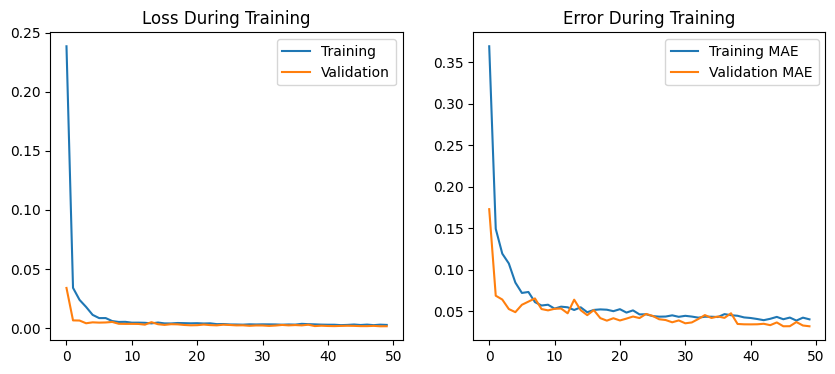

In [77]:
# Build and train the model
def build_stock_predictor(input_shape):
    print(f"Building model for input shape: {input_shape}")
    
    inputs = Input(shape=input_shape)
    
    # Use LSTM layers for time series prediction
    x = tf.keras.layers.LSTM(50, return_sequences=True)(inputs)
    x = tf.keras.layers.LSTM(50, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    
    # Dense layers for final prediction
    x = Dense(25, activation='relu')(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=x)
    
    # Compile with higher learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='mse',
        metrics=['mae']
    )
    
    print(f"Model has {model.count_params():,} parameters")
    return model

# Check data quality
def check_data_quality(X, Y):
    print("Checking data quality...")
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    print(f"Y values: min={Y.min():.4f}, max={Y.max():.4f}, std={Y.std():.4f}")
    
    print(f"First few Y values: {Y[:10]}")
    print(f"Last few Y values: {Y[-10:]}")
    
    unique_values = len(np.unique(Y))
    print(f"Number of unique Y values: {unique_values}")
    
    if Y.std() < 0.01:
        print("WARNING: Y values barely change - this will cause flat predictions!")
        print("Consider using a different time period or different data")
    
    return Y.std() > 0.01

# Check the data
data_is_good = check_data_quality(X, Y)

if data_is_good:
    print("Building LSTM model...")
    model = build_stock_predictor(input_shape=(X.shape[1], X.shape[2]))
    
    print("Starting training...")
    history = model.fit(
        X, Y,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    print("Training done!")
    
    # Show training progress
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss During Training')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Error During Training')
    plt.legend()
    
    plt.show()
    
else:
    print("Data doesn't vary enough for meaningful predictions")
    print("Try getting data from a different time period")

After the training is completed, we need to evaluate prediction performance.  In order to do this, we will use the trained model to predict future values in the time series and visualize results.

Making predictions...
Average error: $0.08
RMS error: $0.11


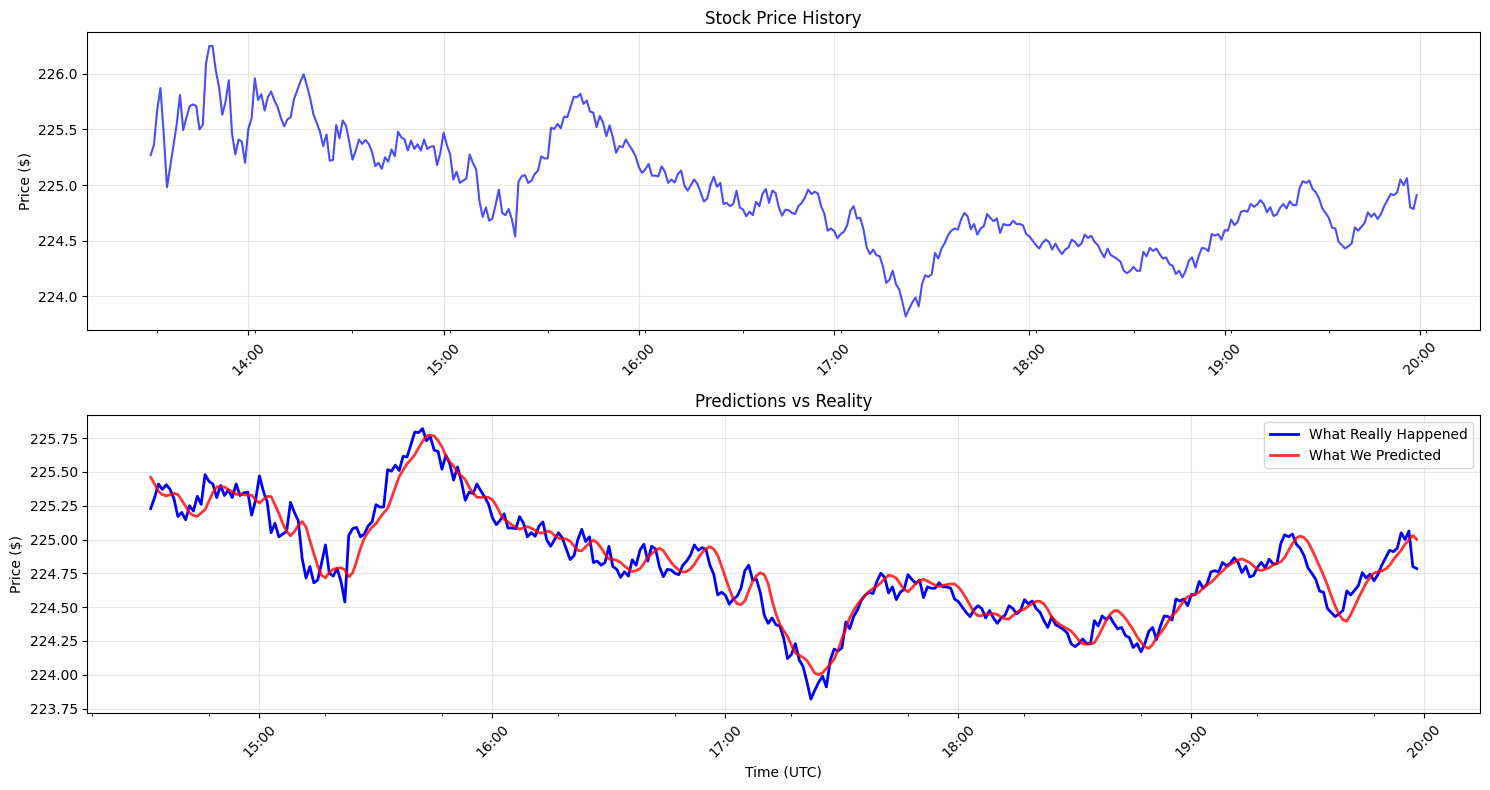

Done checking results!


In [83]:
# See how well our model did
def check_predictions(model, X, Y, scaler, original_prices):
    print("Making predictions...")
    
    # Get model predictions
    pred_scaled = model.predict(X, verbose=0)
    predictions = scaler.inverse_transform(pred_scaled)
    
    # Convert actual values back to dollars
    actual = scaler.inverse_transform(Y.reshape(-1, 1))
    
    # Calculate errors
    error = np.abs(predictions - actual)
    avg_error = np.mean(error)
    rms_error = np.sqrt(np.mean((predictions - actual) ** 2))
    
    print(f"Average error: ${avg_error:.2f}")
    print(f"RMS error: ${rms_error:.2f}")
    
    # Create plots with proper time formatting
    import matplotlib.dates as mdates
    plt.figure(figsize=(15, 8))
    
    # Show the original price data with actual timestamps
    plt.subplot(2, 1, 1)
    plt.plot(original_prices.index, original_prices.values, alpha=0.7, color='blue')
    plt.title('Stock Price History')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    
    # Format x-axis to show times properly
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Every hour
    plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))  # Every 30 minutes
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Show as HH:MM
    plt.xticks(rotation=45)
    
    # Compare predictions to actual with timestamps
    plt.subplot(2, 1, 2)
    # Get the timestamps for the prediction period
    lookback_window = X.shape[1]
    prediction_timestamps = original_prices.index[lookback_window:lookback_window + len(actual)]
    
    plt.plot(prediction_timestamps, actual, label='What Really Happened', linewidth=2, color='blue')
    plt.plot(prediction_timestamps, predictions, label='What We Predicted', linewidth=2, alpha=0.8, color='red')
    
    plt.title('Predictions vs Reality')
    plt.xlabel('Time (UTC)')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format x-axis to show times properly
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Major ticks every hour
    plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))  # Minor ticks every 30 min
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return predictions, actual

# Run the evaluation
predictions, actual_prices = check_predictions(model, X, Y, scaler, original_prices)
print("Done checking results!")